# Analysis
Created by Ivan Lima on 2020-04-07 20:11:35 

In this notebook we examine gender differences in NSF Ocean Sciences awards between 1987 and 2019. The metrics we use for gender discrepancies are the annual fraction of female PIs and co-PIs in the awards. We track those metrics across: 

1. All NSF-OCE awards.
2. Awards from the top 10 largest NSF programs (in number of awards).
3. Across the top 10 academic organizations (in number of awards).
4. Identified research topics.
5. Award types

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import warnings
from tqdm import tnrange, notebook
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 100
pd.options.display.max_columns = 50
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Mon Aug 24 21:05:45 2020


## All NSF-OCE awards

In [2]:
# Read NSF-OCE award data
data_types = {'Abstract':'string', 'Title':'string', 'Programs':'string', 'PI':'string',
              'Organization':'string', 'State':'string', 'Instrument':'string', 'co-PIs':'string',
              'program':'string', 'PI_first_name':'string', 'co-PI_first_name':'string',
              'PI_gender':'string', 'co-PI_gender':'string'}
awards = pd.read_csv('results/awards_1985-2020_clean_edited_grouped_gender_topic.csv', index_col=0,
                     parse_dates=[4,5], dtype=data_types)

topic_probs = pd.read_csv('results/topic_probs.csv', index_col=0)
topic_words = pd.read_csv('results/topic_words.csv', index_col=0)

npzfile = np.load('results/NMF_TSNE.npz')
feature_names  = npzfile['feature_names']
nmf_components = npzfile['nmf_components']
topic_names    = npzfile['topic_names']
topic_names_r  = npzfile['topic_names_r']
X_tsne         = npzfile['X_tsne']
npzfile.close()
# awards.info()

# Read geosciences/atmospheric/ocean sciences academic gender workforce data
workforce = pd.read_csv('data/nsf_workforce.csv')#, index_col=0)
workforce['female_frac'] = workforce.female/workforce.total

The figure below shows the number of awards and the amount awarded by NSF Ocean Sciences per year, and a box plot of the amount awarded to individual projects in each year between 1987 and 2019.

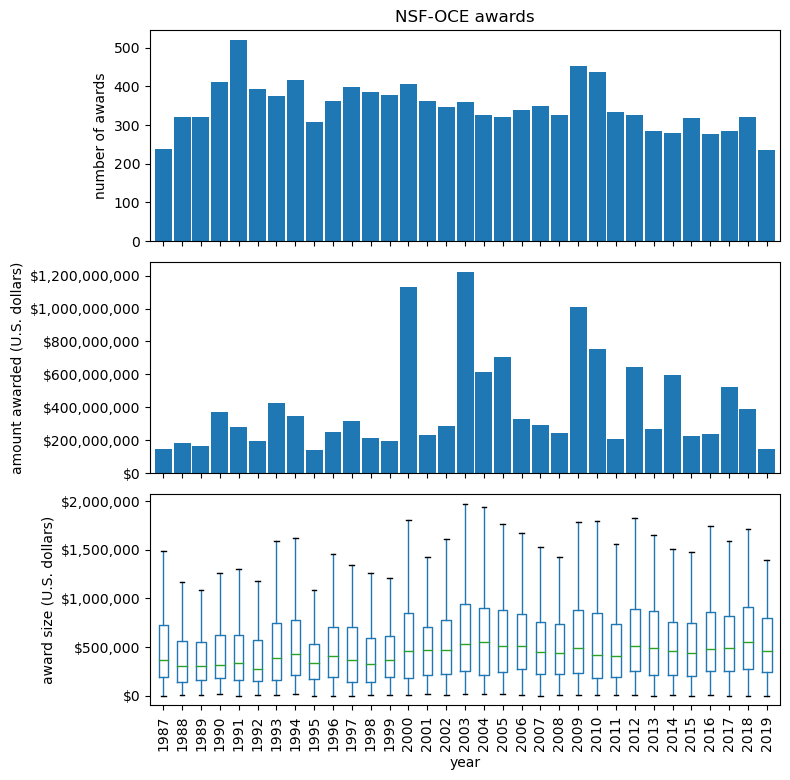

In [3]:
from matplotlib import ticker
def dollar(x, pos):
    return '${:,.0f}'.format(x)
fmt = ticker.FuncFormatter(dollar)

number_per_year = awards.groupby(awards.StartDate.dt.year)['Abstract'].count()
amount_per_year = awards.groupby([awards.StartDate.dt.year])['tot_amount_adjusted'].sum()
awards['year'] = awards.StartDate.dt.year

fig, axs = plt.subplots(3, 1, figsize=(9,9))
_ = number_per_year.plot(kind='bar',ax=axs[0], width=0.9, legend=False)
_ = axs[0].set(title='NSF-OCE awards', ylabel='number of awards', xticklabels='', xlabel='')
_ = amount_per_year.plot(kind='bar',ax=axs[1], width=0.9)
_ = axs[1].yaxis.set_major_formatter(fmt)
_ = axs[1].set(ylabel='amount awarded (U.S. dollars)', xticklabels='', xlabel='')
_ = awards.boxplot('tot_amount_adjusted', by='year', showfliers=False,rot=90, grid=False, ax=axs[2])
_ = axs[2].yaxis.set_major_formatter(fmt)
_ = axs[2].set(title='', ylabel='award size (U.S. dollars)')
_ = axs[2].set_xlim(0.3, 33.7)
fig.suptitle('')
fig.subplots_adjust(left=0.2, hspace=0.1)

The figure below shows the time series of the annual fraction of female PIs and co-PIs across all awards and the fraction of females in the academic workforce between 1987 and 2019. 
<!-- Solid lines represent a 3-year sliding window average (except for workforce data) and points represent the individual years. -->

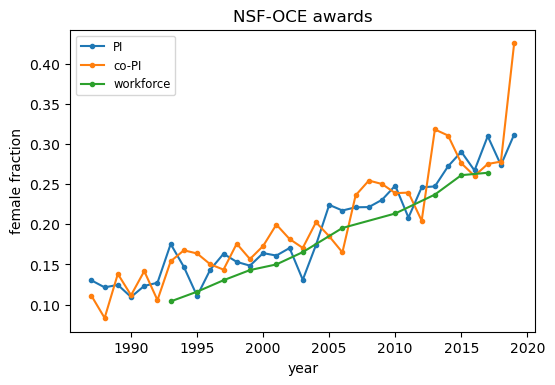

In [4]:
# female & male fraction of PIs
pi_gender = awards.groupby([awards.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender = pi_gender.divide(pi_gender.sum(axis=1), axis=0)

# female & male fraction of co-PIs
copi_gender = pd.DataFrame({'female':awards.groupby(awards.StartDate.dt.year)['co-PI_female_frac'].mean()})
copi_gender['male'] = 1 - copi_gender.female

# female fraction of PIs & co-PIs
female_frac = pd.DataFrame({'PI':pi_gender['female'], 'co-PI':copi_gender['female']})
female_frac.index.rename('year',inplace=True)

fig, ax = plt.subplots()
_ = female_frac.plot(ax=ax, style='.-', legend=False)
# _ = female_frac.plot(ax=ax, style=['C0.','C1.'],legend=False, alpha=0.5)
# _ = female_frac.rolling(3,center=True).mean().plot(ax=ax, legend=False)
_ = workforce.plot(x='year', y='female_frac', ax=ax, style='.-', label='workforce', legend=False)
_ = ax.set(title='NSF-OCE awards', ylabel='female fraction')
lines = ax.get_lines()
_ = ax.legend(lines,['PI','co-PI','workforce'])

The temporal trends seem to be linear

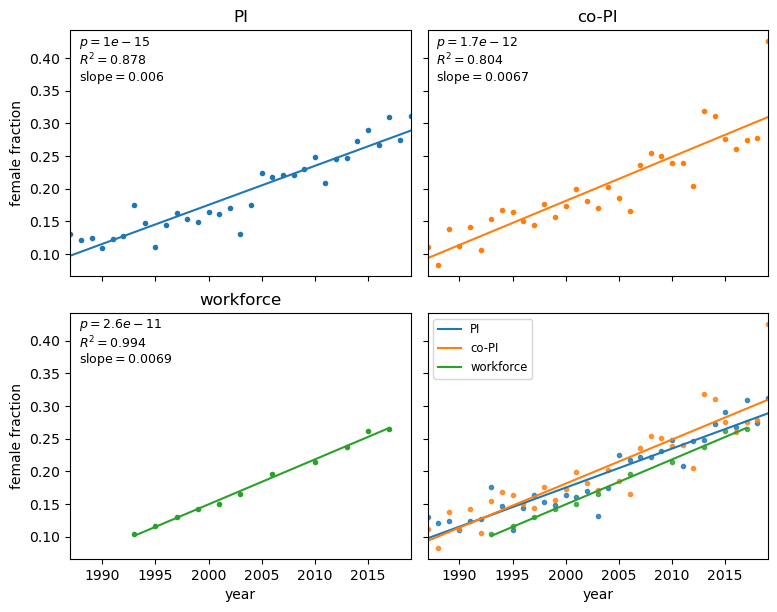

In [5]:
import statsmodels.api as sm
import seaborn as sns

def linreg(x, y):
    X = sm.add_constant(x)
    lreg = sm.OLS(y,X).fit()
    return lreg, X

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 7))
fig.subplots_adjust(wspace=0.05, hspace=0.15)

_ = female_frac.PI.plot(ax=axs[0,0], style='C0.')
_ = axs[0,0].set(title='PI', ylabel='female fraction')

_ = female_frac['co-PI'].plot(ax=axs[0,1], style='C1.')
_ = axs[0,1].set(title='co-PI', ylabel='female fraction')

_ = workforce.plot(x='year', y='female_frac', ax=axs[1,0], style='C2.', legend=False)
_ = axs[1,0].set(title='workforce', ylabel='female fraction')

for ax, x, y, s in zip(axs.ravel(),[female_frac.index, female_frac.index, workforce.year],
                       [female_frac.PI, female_frac['co-PI'], workforce.female_frac],['C0-','C1-','C2-']):
    reg, X = linreg(x, y)
    p, slope, rsquared = reg.pvalues[1], reg.params[1], reg.rsquared
    _ = ax.plot(x, reg.predict(X), s)
    _ = ax.text(0.025,0.95, '$p={:.2g}$'.format(p), transform=ax.transAxes, ha='left',
                va='center', fontsize=9)
    _ = ax.text(0.025,0.88, '$R^2={:.3g}$'.format(rsquared), transform=ax.transAxes, ha='left',
                va='center', fontsize=9)
    _ = ax.text(0.025,0.81, 'slope$={:.2g}$'.format(slope), transform=ax.transAxes, ha='left',
                va='center', fontsize=9)
    
_ = sns.regplot(female_frac.index,female_frac.PI, ax=axs[1,1], marker='.', ci=None, line_kws={'linewidth':1.5})
_ = sns.regplot(female_frac.index,female_frac['co-PI'], ax=axs[1,1], marker='.', ci=None, line_kws={'linewidth':1.5})
_ = sns.regplot(workforce.year,workforce.female_frac, ax=axs[1,1], marker='.', ci=None, line_kws={'linewidth':1.5})
lines = axs[1,1].get_lines()
_ = axs[1,1].legend(lines,['PI','co-PI','workforce'], loc='upper left')

The table below shows the results of a multivariate linear regression analysis including all NSF-OCE award and workforce data and using "PI", "co-PI" and "workforce" as categorical variables. The difference between female representation in PIs and co-PIs is not statistically significant. But female fraction in the workforce is lower (statistically significant difference) than in NSF-OCE awards. This difference is probably because the workforce data represents a wider range of fields, including earth, atmospheric and ocean sciences. The regression slopes for the award and workforce data are very similar (~0.006).

In [6]:
import statsmodels.formula.api as smf

df1 = pd.DataFrame({'fem_frac':female_frac['PI'], 'category':'PI'})
df2 = pd.DataFrame({'fem_frac':female_frac['co-PI'], 'category':'co-PI'})
df3 = pd.DataFrame({'fem_frac':workforce.set_index('year').female_frac, 'category':'workforce'})
df  = pd.concat([df1,df2,df3]).reset_index()
lreg = smf.ols(formula='fem_frac ~ year + category', data=df)
res = lreg.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               fem_frac   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     137.7
Date:                Mon, 24 Aug 2020   Prob (F-statistic):           5.67e-30
Time:                        21:05:50   Log-Likelihood:                 173.83
No. Observations:                  77   AIC:                            -339.7
Df Residuals:                      73   BIC:                            -330.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -12.6619      0.637    -19.873      0.000     -13.932     -11.392
category[T.co-PI]         0.0085      0.006      1.325      0.189      -0.004       0.021
category[T.workforce]    -0.0223      0.009     -2.461      0.016      -0.040      -0.004
year                      0.0064      0.000     20.177      0.000       0.006       0.007
==============================================================================
Omnibus:                       32.343   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.881
Skew:                           1.167   Prob(JB):                     2.07e-27
Kurtosis:                       8.732   Cond. No.                     4.31e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Top 10 NSF programs

### In number of awards

The table and histogram below show the top 10 NSF-OCE programs in number of awards for the period 1987-2019.

In [7]:
awards.loc[awards.program=='DATA NOT AVAILABLE','program'] = np.nan
top10_programs = pd.DataFrame({'number of awards':
                      awards.groupby('program')['Abstract'].count().sort_values(ascending=False)[:10]})
top10_programs['percentage of total'] = top10_programs['number of awards'] / len(awards) * 100
top10_programs

,number of awards,percentage of total
program,,
MARINE GEOLOGY AND GEOPHYSICS,2577,22.383393
BIOLOGICAL OCEANOGRAPHY,2121,18.422653
PHYSICAL OCEANOGRAPHY,1835,15.938504
CHEMICAL OCEANOGRAPHY,1347,11.699818
OCEAN TECH & INTERDISC COORDIN,475,4.125771
OCEANOGRAPHIC INSTRUMENTATION,453,3.934683
SHIPBOARD SCIENTIFIC SUPP EQUI,377,3.274559
OCEAN DRILLING PROGRAM,281,2.440719
EDUCATION/HUMAN RESOURCES,249,2.162773


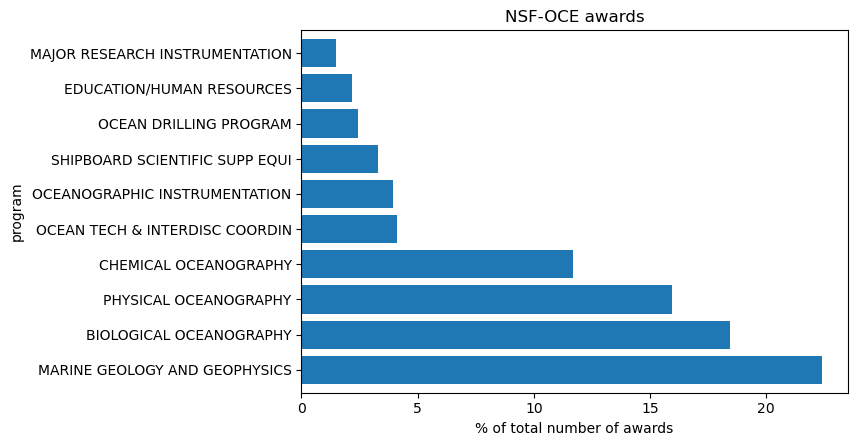

In [8]:
fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = top10_programs['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total number of awards')

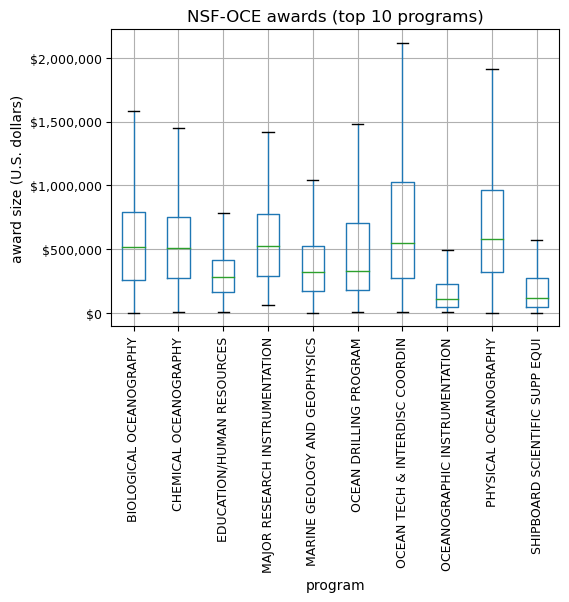

In [9]:
df = awards[awards.program.isin(top10_programs.index)]
fig, ax = plt.subplots(figsize=(6.4, 6.6))
_ = df.boxplot('tot_amount_adjusted', by='program', showfliers=False, rot=90, fontsize=9, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='NSF-OCE awards (top 10 programs)', ylabel='award size (U.S. dollars)')
fig.suptitle('')
fig.subplots_adjust(left=0.2, bottom=0.45)

The figure below shows the time series of the number of awards and the percentage of awards per year for each of the top 10 programs.

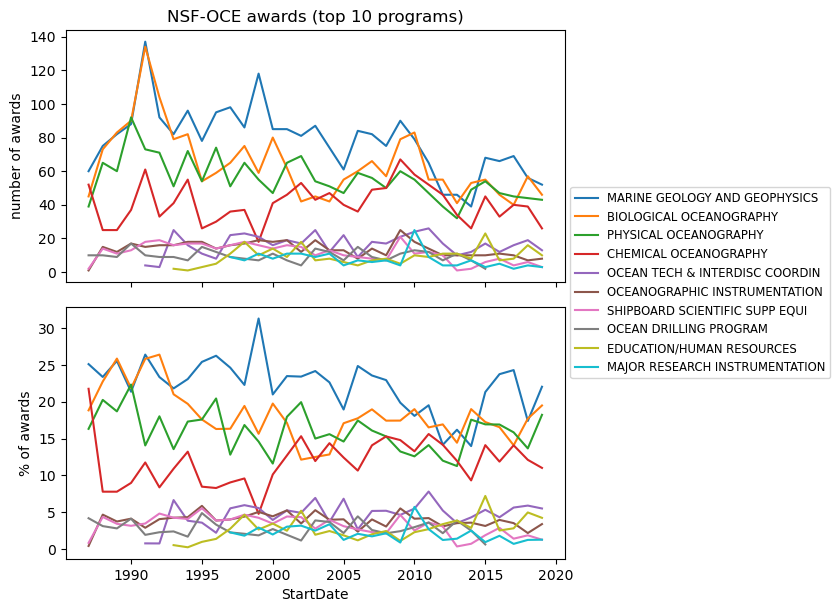

In [10]:
prog_year = awards.groupby([awards.StartDate.dt.year,'program'])['Abstract'].count().unstack()
prog_year = prog_year[top10_programs.index]
num_awards_per_year = awards.groupby([awards.StartDate.dt.year])['Abstract'].count()
prog_year_pct = prog_year.divide(num_awards_per_year,axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, hspace=0.1)
_ = prog_year.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('number of awards')
_ = axs[0].set_title('NSF-OCE awards (top 10 programs)')
_ = prog_year_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of awards')

### In total amount awarded

The table and histogram below show the top 10 NSF-OCE programs in total amount awarded for the period 1987-2019.

In [11]:
top10_programs_amount = pd.DataFrame({'amount awarded':
    awards.groupby('program')['tot_amount_adjusted'].sum().sort_values(ascending=False)[:10]})
top10_programs_amount['percentage of total'] = (top10_programs_amount['amount awarded'] /
                                         awards.tot_amount_adjusted.sum() * 100)
top10_programs_amount.style.format('${0:,.2f}', subset='amount awarded')

,amount awarded,percentage of total
program,,
PHYSICAL OCEANOGRAPHY,"$1,733,384,196.35",13.022919
BIOLOGICAL OCEANOGRAPHY,"$1,497,038,872.21",11.247256
MARINE GEOLOGY AND GEOPHYSICS,"$1,305,635,469.81",9.809242
OCEAN DRILLING PROGRAM,"$1,184,717,727.14",8.900787
SHIP OPERATIONS,"$945,984,461.72",7.107183
SODV - CONSTRUCTION,"$847,242,483.59",6.365334
CHEMICAL OCEANOGRAPHY,"$788,216,809.37",5.921874
OCEAN TECH & INTERDISC COORDIN,"$490,624,932.12",3.686066
OCEAN OBSERV INIT-CONSTRUCTION,"$460,170,552.23",3.457262


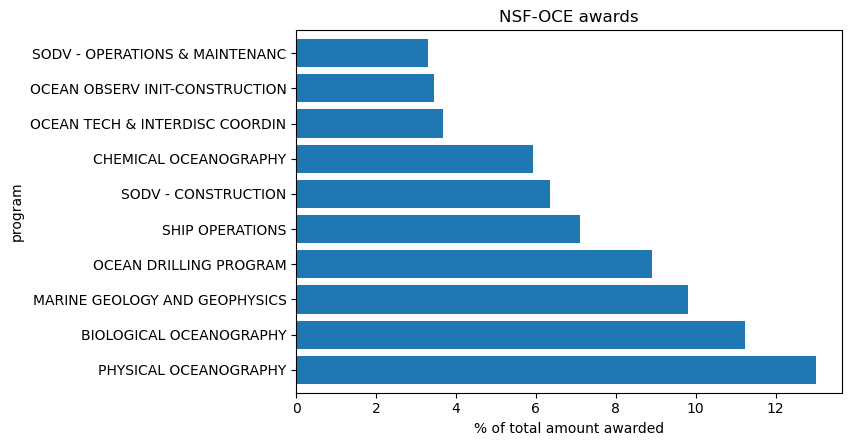

In [12]:
fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = top10_programs_amount['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total amount awarded')

The figure below shows the time series of the amount awarded and the percentage of the amount awarded per year for each of the top 10 programs.

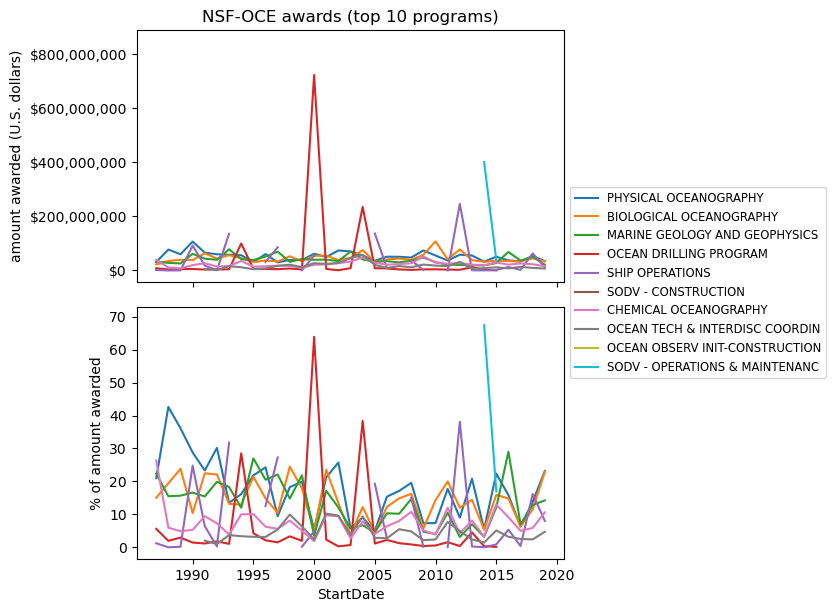

In [13]:
prog_year_amount = awards.groupby(
    [awards.StartDate.dt.year,'program'])['tot_amount_adjusted'].sum().unstack()
prog_year_amount = prog_year_amount[top10_programs_amount.index]
prog_year_amount_pct = prog_year_amount.divide(amount_per_year, axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, left=0.2, hspace=0.1)
_ = prog_year_amount.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('amount awarded (U.S. dollars)')
_ = axs[0].set_title('NSF-OCE awards (top 10 programs)')
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = prog_year_amount_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of amount awarded')

### Changes in gender composition across top 10 programs (in number of awards)

The figure below shows time series of the annual fraction of female PIs and co-PIs for each of the top 10 NSF-OCE programs (in number of awards). Solid lines represent a 3-year sliding window average and points represent the individual years.

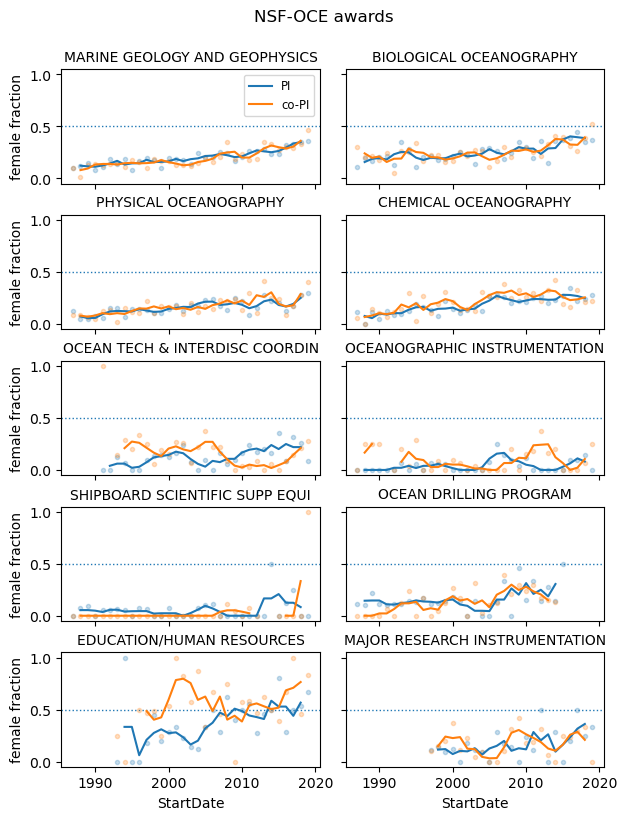

In [14]:
# female & male fraction of PIs
df_prog = awards[awards.program.isin(top10_programs.index)]
df = df_prog.groupby(['program',df_prog.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender_by_program = df.fillna(0).divide(df.sum(axis=1), axis=0)

# female & male fraction of co-PIs
copi_gender_by_program = pd.DataFrame({'female': 
                   df_prog.groupby(['program',df_prog.StartDate.dt.year])['co-PI_female_frac'].mean()})
copi_gender_by_program['male'] = 1 - copi_gender_by_program.female

# female fraction of PIs & co-PIs
female_frac_by_program = pd.DataFrame({'PI':pi_gender_by_program['female'],
                                       'co-PI':copi_gender_by_program['female']})

nn = 3 # size of moving window (years)
alpha = 0.25

fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(7, 9))
fig.subplots_adjust(hspace=0.275, wspace=0.1, top=0.9)
for ax, prog in zip(axs.ravel(), top10_programs.index):
    if prog == 'MARINE GEOLOGY AND GEOPHYSICS':
        legend = True
    else:
        legend=False
    _ = female_frac_by_program.loc[prog].plot(ax=ax, style=['C0.','C1.'],legend=False, alpha=alpha)
    _ = female_frac_by_program.loc[prog].rolling(nn, center=True).mean().plot(ax=ax, legend=legend)
    _ = ax.set_title(prog, fontsize=10)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(0.5, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)    
for i in range(5):
    _ = axs[i,0].set_ylabel('female fraction')
_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

In [15]:
# fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9,8))
# for ax, prog in zip(axs.ravel(),
#                     ['MARINE GEOLOGY AND GEOPHYSICS','BIOLOGICAL OCEANOGRAPHY', 'PHYSICAL OCEANOGRAPHY', 'CHEMICAL OCEANOGRAPHY']):
#     df = female_frac_by_program.loc[prog]
#     _ = sns.regplot(df.index, df.PI, ax=ax)
#     _ = sns.regplot(df.index, df['co-PI'], ax=ax)
#     _ = ax.set_title(prog)

## Top 10 academic organizations

In [16]:
# shorten some organization names
awards.loc[awards.Organization == 'University of Miami Rosenstiel School of Marine&Atmospheric Sci',
           'Organization'] = 'University of Miami RSMAS'
awards.loc[awards.Organization == 'University of California-San Diego Scripps Inst of Oceanography',
           'Organization'] = 'UCSD Scripps Institution of Oceanography'

### In number of awards

The table and histogram below show the top 10 academic organizations in number of awards for the period 1987-2019.

In [17]:
top10_orgs = pd.DataFrame(
    {'number of awards':
     awards.groupby('Organization')['Abstract'].count().sort_values(ascending=False)[:10]})
top10_orgs['percentage of total'] = top10_orgs['number of awards']/len(awards)*100
top10_orgs

,number of awards,percentage of total
Organization,,
Woods Hole Oceanographic Institution,1600,13.897333
UCSD Scripps Institution of Oceanography,807,7.009468
Columbia University,602,5.228872
University of Washington,598,5.194128
Oregon State University,569,4.942239
University of Hawaii,502,4.360288
University of Miami RSMAS,323,2.805524
University of Rhode Island,299,2.597064
University of Delaware,198,1.719795


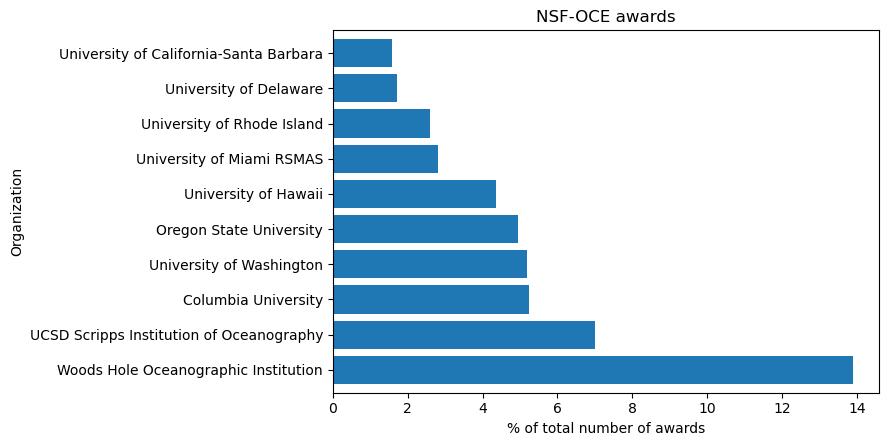

In [18]:
fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = top10_orgs['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total number of awards')

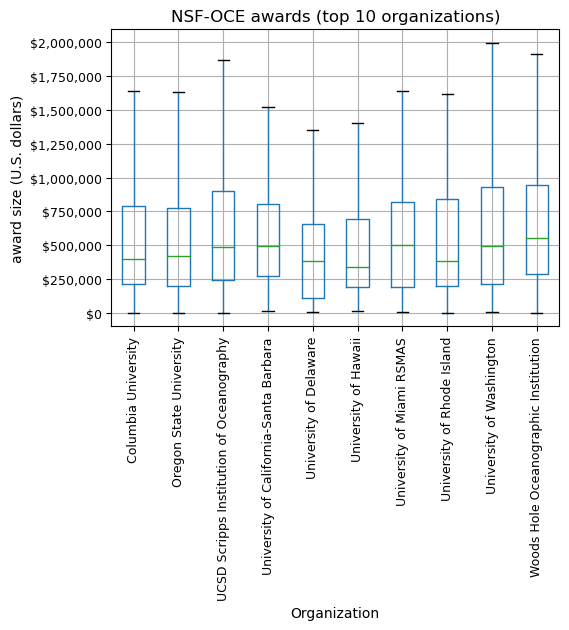

In [19]:
df = awards[awards.Organization.isin(top10_orgs.index)]
fig, ax = plt.subplots(figsize=(6.4, 6.6))
_ = df.boxplot('tot_amount_adjusted', by='Organization', showfliers=False, rot=90, fontsize=9, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='NSF-OCE awards (top 10 organizations)', ylabel='award size (U.S. dollars)')
fig.suptitle('')
fig.subplots_adjust(left=0.2, bottom=0.45)

The figure below shows the time series of the number of awards and the percentage of awards per year for each of the top 10 organizations.

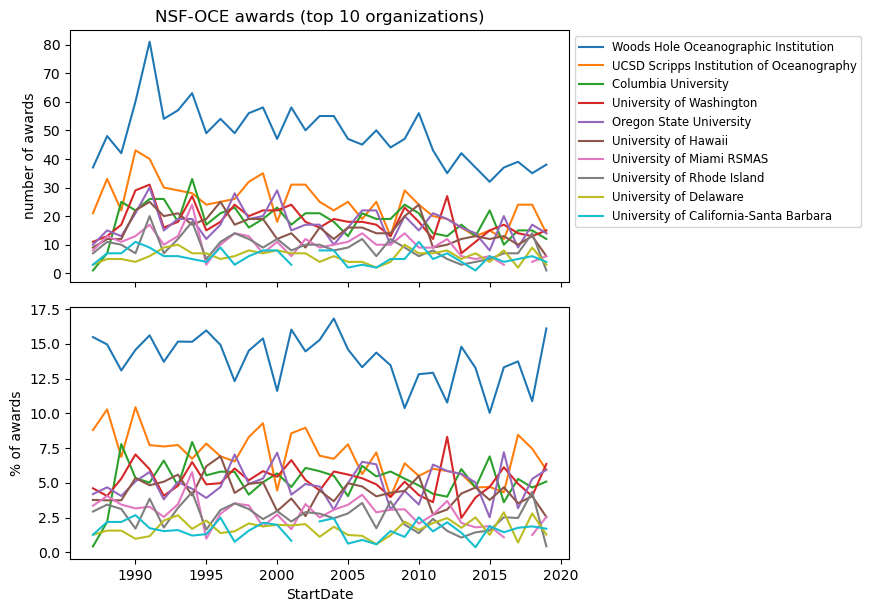

In [20]:
org_year = awards.groupby([awards.StartDate.dt.year,'Organization'])['Abstract'].count().unstack()
org_year = org_year[top10_orgs.index]
org_year_pct = org_year.divide(num_awards_per_year,axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, hspace=0.1)
_ = org_year.plot(ax=axs[0]).legend(bbox_to_anchor=(1, 1))
_ = axs[0].set_ylabel('number of awards')
_ = axs[0].set_title('NSF-OCE awards (top 10 organizations)')
_ = org_year_pct.plot(ax=axs[1], legend=False)
_ = axs[1].set_ylabel('% of awards')

### In total amount awarded

The table and histogram below show the top 10 academic organizations in total amount awarded for the period 1987-2019.

In [21]:
top10_orgs_amount = pd.DataFrame(
    {'amount awarded':
     awards.groupby('Organization')['tot_amount_adjusted'].sum().sort_values(ascending=False)[:10]})
top10_orgs_amount['percentage of total'] = (top10_orgs_amount['amount awarded']/
                                     awards.tot_amount_adjusted.sum()*100)
top10_orgs_amount.style.format('${0:,.2f}', subset='amount awarded')

,amount awarded,percentage of total
Organization,,
"Consortium for Ocean Leadership, Inc","$2,566,628,770.88",19.283087
Woods Hole Oceanographic Institution,"$2,173,323,408.21",16.328183
UCSD Scripps Institution of Oceanography,"$984,540,895.39",7.396858
Oregon State University,"$775,361,298.13",5.825291
Columbia University,"$719,521,492.45",5.405766
University of Washington,"$557,513,396.54",4.188599
Texas A&M Research Foundation,"$462,583,353.02",3.475390
University of Hawaii,"$449,643,249.02",3.378171
University of Alaska Fairbanks Campus,"$348,221,594.82",2.616190


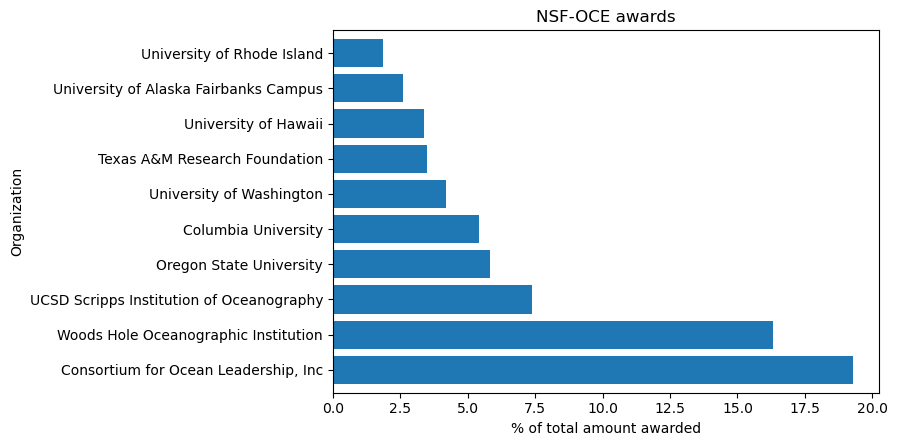

In [22]:
fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = top10_orgs_amount['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total amount awarded')

The figure below shows the time series of the amount awarded and percentage of the amount awarded per year for each of the top 10 organizations.

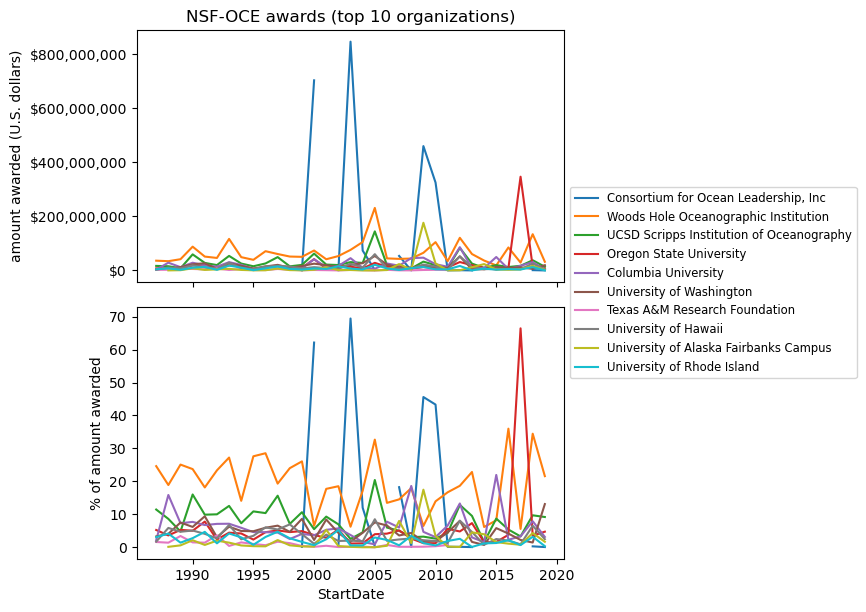

In [23]:
org_year_amount = awards.groupby(
    [awards.StartDate.dt.year,'Organization'])['tot_amount_adjusted'].sum().unstack()
org_year_amount = org_year_amount[top10_orgs_amount.index[0:]]
org_year_amount_pct = org_year_amount.divide(amount_per_year, axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, left=0.2, hspace=0.1)
_ = org_year_amount.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('amount awarded (U.S. dollars)')
_ = axs[0].set_title('NSF-OCE awards (top 10 organizations)')
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = org_year_amount_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of amount awarded')

### Changes in gender composition across top 10 organizations

The figure below shows time series of the annual fraction of female PIs and co-PIs for each of the top 10 academic organizations (in number of awards). Solid lines represent a 3-year sliding window average and points represent the individual years.

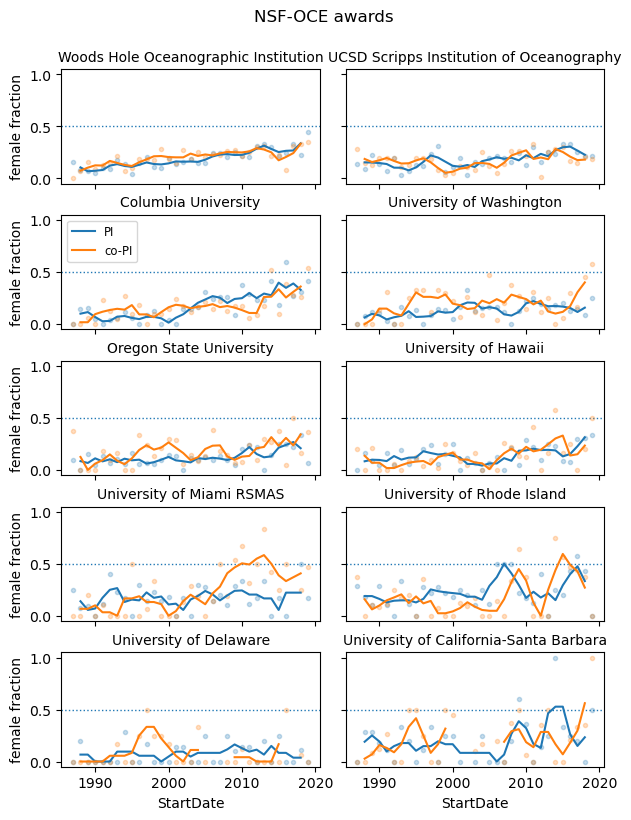

In [24]:
# female & male fraction of PIs
df_org = awards[awards.Organization.isin(top10_orgs.index)]
df = df_org.groupby(['Organization',df_org.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender_by_org = df.fillna(0).divide(df.sum(axis=1), axis=0)

# female & male fraction of co-PIs
copi_gender_by_org = pd.DataFrame({'female': 
                   df_org.groupby(['Organization',df_org.StartDate.dt.year])['co-PI_female_frac'].mean()})
copi_gender_by_org['male'] = 1 - copi_gender_by_org.female

female_frac_by_org = pd.DataFrame({'PI':pi_gender_by_org['female'], 'co-PI': copi_gender_by_org['female']})

fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(7, 9))
fig.subplots_adjust(hspace=0.275, wspace=0.1, top=0.9)
for ax, org in zip(axs.ravel(), top10_orgs.index):
    if org == 'Columbia University':
        legend = True
    else:
        legend=False
    _ = female_frac_by_org.loc[org].plot(ax=ax, style=['C0.','C1.'], legend=False, alpha=alpha)
    _ = female_frac_by_org.loc[org].rolling(nn,center=True).mean().plot(ax=ax, legend=legend)
    _ = ax.set_title(org, fontsize=10)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(0.5, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)    
for i in range(5):
    _ = axs[i,0].set_ylabel('female fraction')
_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

## Research topics

Similarly to what was done in [Lima & Rheuban, 2018](https://tos.org/oceanography/article/topics-and-trends-in-nsf-ocean-sciences-awards), we applied non-negative matrix factorization (NMF) to the NSF-OCE abstracts to extract 22 research topics.

### Changes in gender composition across research topics

The figure below shows time series of the annual fraction of female PIs and co-PIs for each of the identified research topics. Solid lines represent a 3-year sliding window average and points represent the individual years.

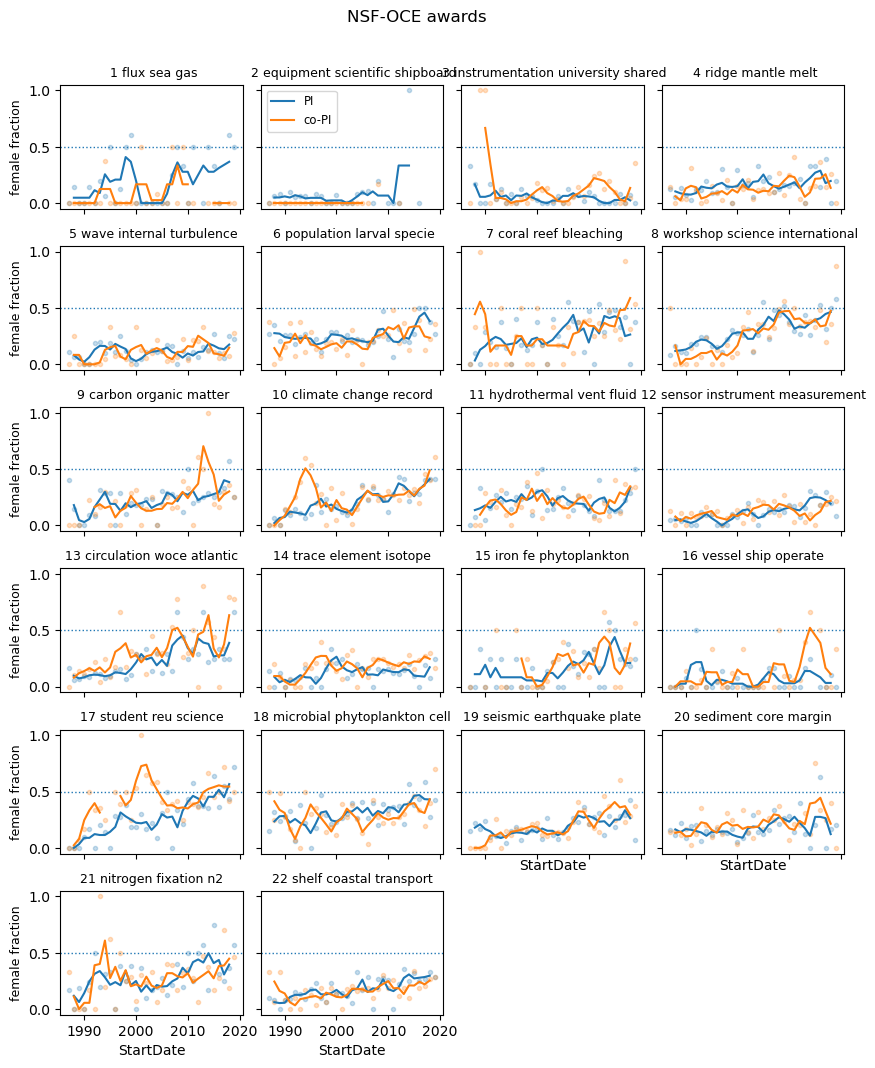

In [25]:
df = awards.groupby(['topic',awards.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender_by_topic = df.fillna(0).divide(df.sum(axis=1), axis=0)

copi_gender_by_topic = pd.DataFrame(
    {'female':awards.groupby(['topic', awards.StartDate.dt.year])['co-PI_female_frac'].mean()})
copi_gender_by_topic['male'] = 1 - copi_gender_by_topic.female
copi_gender_by_topic

female_frac_by_topic = pd.DataFrame({'PI':pi_gender_by_topic.female, 'co-PI':copi_gender_by_topic.female})

fig, axs = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(9.5,12))
fig.subplots_adjust(hspace=0.3, wspace=0.1, top=0.9, right=0.95)
fig.delaxes(axs[5,3])
fig.delaxes(axs[5,2])
for ax, t in zip(axs.ravel(), range(1,23)):
    if t == 2:
        legend = True
    else:
        legend=False    
    _ = female_frac_by_topic.loc[t].plot(ax=ax, style=['C0.','C1.'], legend=False, alpha=0.25)
    _ = female_frac_by_topic.loc[t].rolling(nn,center=True).mean().plot(ax=ax, legend=legend)
    _ = ax.set_title(topic_names_r[t-1], fontsize=9)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(0.5, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)
for i in range(6):
    _ = axs[i,0].set_ylabel('female fraction', fontsize=9)
_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

## Award types

Types of awards and initiatives identified in the data include:

- Collaborative Research
- EAGER: EArly-concept Grant For Exploratory Research
- RAPID: Rapid Response Research
- REU: Research Experience for Undergraduates
- RUI: Research in Undergraduate Institutions
- SGER: Small Grants for Exploratory Research
- CAREER: Faculty Early Career Development
- CMG: Collaboration in Mathematical Geosciences
- POWRE: Professional Opportunities for Women in Research and Education

SGER seems to be an older denomination for EAGER awards. Therefore we are grouping these two types of awards together as EAGER awards.

In [26]:
# awards = awards.drop('award_type', axis=1)
awards.loc[awards.Title.str.contains('collaborative\s'),'award_type'] = 'Collaborative Research'
awards.loc[awards.Title.str.contains('eager\s'),'award_type'] = 'EAGER'
awards.loc[awards.Title.str.contains('rapid\s'),'award_type'] = 'RAPID'
awards.loc[awards.Title.str.contains('sger\s'),'award_type'] = 'EAGER'
awards.loc[awards.Title.str.contains('reu\s'),'award_type'] = 'REU'
awards.loc[awards.Title.str.contains('rui\s'),'award_type'] = 'RUI'
awards.loc[awards.Title.str.contains('career\s'),'award_type'] = 'CAREER'
awards.loc[awards.Title.str.contains('cmg\s'),'award_type'] = 'CMG'
awards.loc[awards.Title.str.contains('powre\s'),'award_type'] = 'POWRE'
awards['award_type'] = awards.award_type.fillna('standard')

### Number of awards

In [27]:
atypes = pd.DataFrame({'number of awards': awards.award_type.value_counts()})
atypes['percentage of total'] =  atypes['number of awards'] / len(awards) * 100
atypes

,number of awards,percentage of total
standard,8468,73.551637
Collaborative Research,1987,17.258751
EAGER,348,3.022670
RAPID,245,2.128029
REU,236,2.049857
CAREER,108,0.938070
RUI,88,0.764353
CMG,20,0.173717
POWRE,13,0.112916


The number and percentage of each award type in each year between 1987 2019.

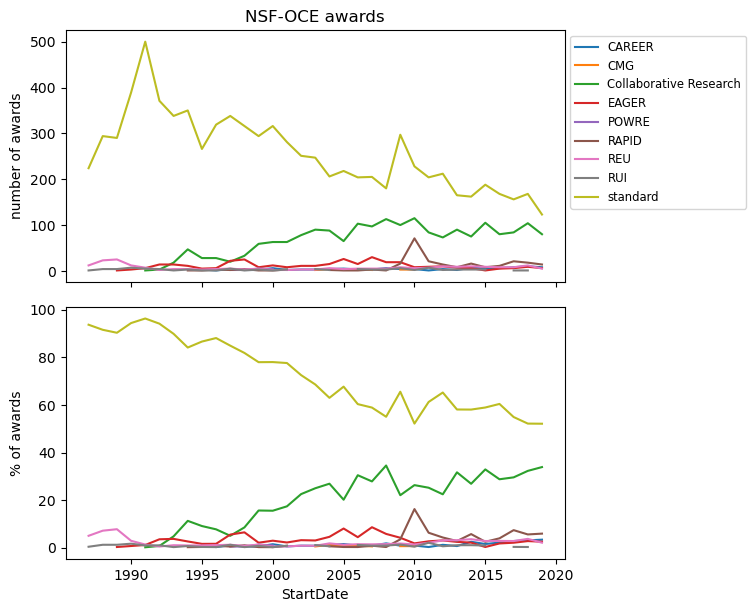

In [28]:
atype_year = awards.groupby([awards.StartDate.dt.year,'award_type'])['Abstract'].count().unstack()
atype_year_pct = atype_year.divide(num_awards_per_year,axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, hspace=0.1)
_ = atype_year.plot(ax=axs[0]).legend(bbox_to_anchor=(1, 1))
_ = axs[0].set_ylabel('number of awards')
_ = axs[0].set_title('NSF-OCE awards')
_ = atype_year_pct.plot(ax=axs[1], legend=False)
_ = axs[1].set_ylabel('% of awards')

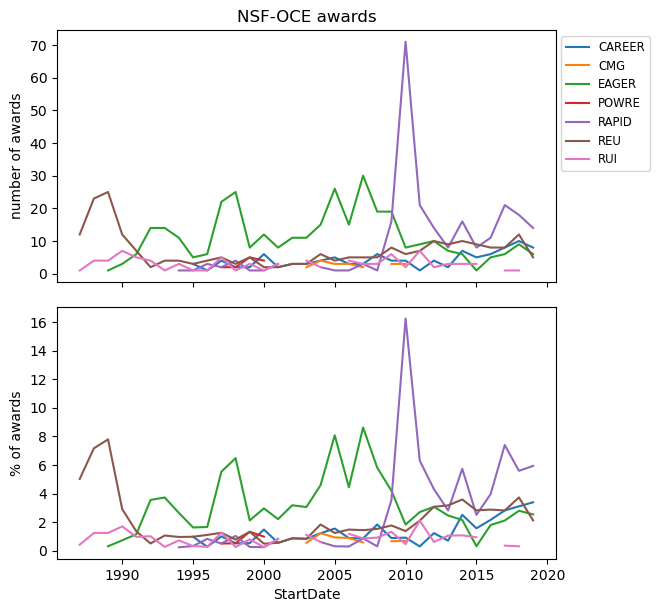

In [29]:
types = ['CAREER','CMG','EAGER','POWRE','RAPID','REU','RUI']
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, hspace=0.1)
_ = atype_year[types].plot(ax=axs[0]).legend(bbox_to_anchor=(1.2, 1))
_ = axs[0].set_ylabel('number of awards')
_ = axs[0].set_title('NSF-OCE awards')
_ = atype_year_pct[types].plot(ax=axs[1], legend=False)
_ = axs[1].set_ylabel('% of awards')

### Amount awarded

In [30]:
atype_amount = pd.DataFrame(
    {'amount awarded':
     awards.groupby('award_type')['tot_amount_adjusted'].sum().sort_values(ascending=False)})
atype_amount['percentage of total'] = (atype_amount['amount awarded'] / atype_amount['amount awarded'].sum()
                                       * 100)
atype_amount.style.format('${0:,.2f}', subset='amount awarded')

,amount awarded,percentage of total
award_type,,
standard,"$11,057,799,224.07",83.077267
Collaborative Research,"$1,923,593,290.87",14.451960
REU,"$102,516,226.11",0.770205
RAPID,"$64,599,009.39",0.485332
CAREER,"$64,394,968.02",0.483800
EAGER,"$42,035,650.80",0.315814
RUI,"$36,333,626.48",0.272975
CMG,"$17,435,101.69",0.130990
POWRE,"$1,551,679.18",0.011658


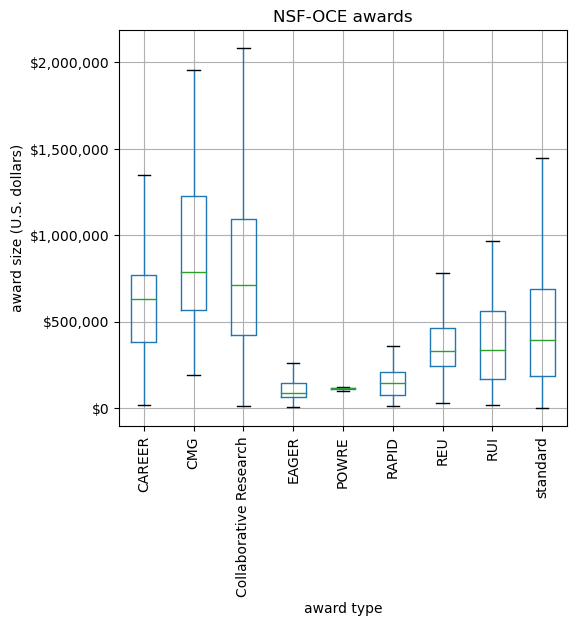

In [31]:
fig, ax = plt.subplots(figsize=(6.4, 6.6))
_ = awards.boxplot('tot_amount_adjusted', by='award_type', showfliers=False, rot=90, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='NSF-OCE awards', ylabel='award size (U.S. dollars)', xlabel='award type')
fig.suptitle('')
fig.subplots_adjust(left=0.2, bottom=0.3)

The annual amount awarded and percentage of annual amount awarded for each award type between 1987 2019.

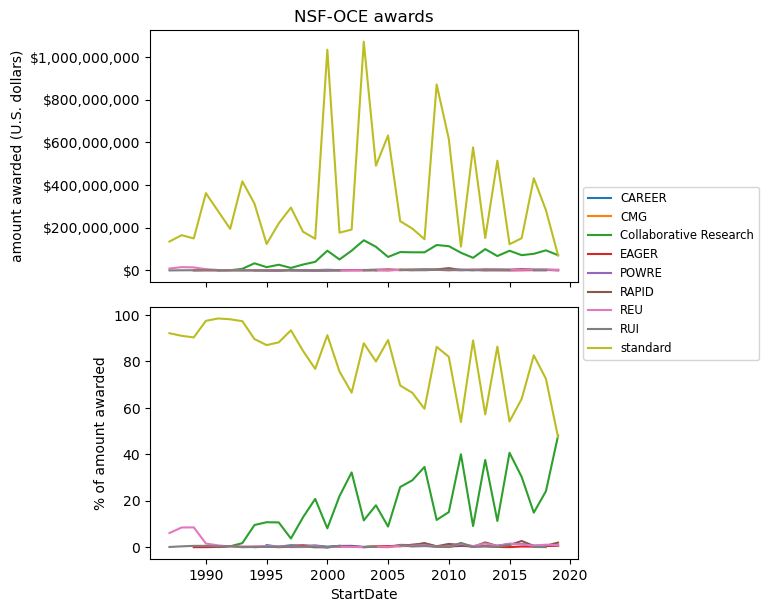

In [32]:
atype_year_amount = awards.groupby(
    [awards.StartDate.dt.year,'award_type'])['tot_amount_adjusted'].sum().unstack()
atype_year_amount_pct = atype_year_amount.divide(amount_per_year, axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, left=0.2, hspace=0.1)
_ = atype_year_amount.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('amount awarded (U.S. dollars)')
_ = axs[0].set_title('NSF-OCE awards')
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = atype_year_amount_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of amount awarded')

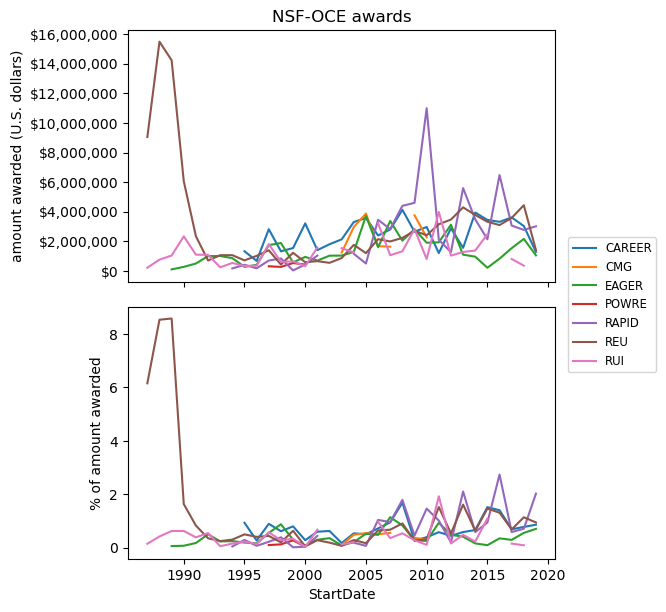

In [33]:
types = ['CAREER','CMG','EAGER','POWRE','RAPID','REU','RUI']
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, left=0.2, hspace=0.1)
_ = atype_year_amount[types].plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('amount awarded (U.S. dollars)')
_ = axs[0].set_title('NSF-OCE awards')
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = atype_year_amount_pct[types].plot(ax=axs[1]).legend(bbox_to_anchor=(1.25, 1.3))
_ = axs[1].set_ylabel('% of amount awarded')

### Changes in gender composition across award types

Except for *Collaborative Research* and *standard* awards, the number of awards per year in each award type is small, therefore the variability is high.

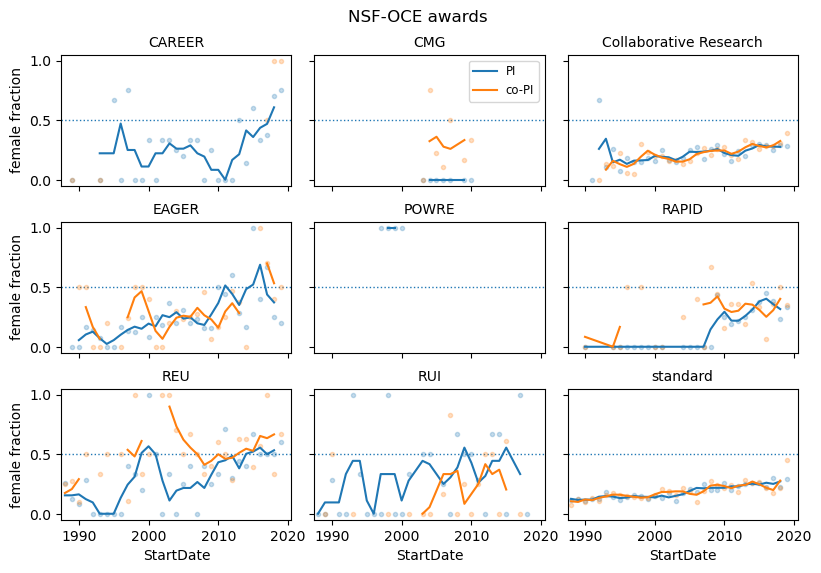

In [34]:
# female & male fraction of PIs
df = awards.groupby(['award_type',awards.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender_by_atype = df.fillna(0).divide(df.sum(axis=1), axis=0)

# female & male fraction of co-PIs
copi_gender_by_atype = pd.DataFrame({'female': 
                   awards.groupby(['award_type',awards.StartDate.dt.year])['co-PI_female_frac'].mean()})
copi_gender_by_atype['male'] = 1 - copi_gender_by_atype.female

female_frac_by_atype = pd.DataFrame({'PI':pi_gender_by_atype['female'],
                                     'co-PI': copi_gender_by_atype['female']})

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9.5, 6))
fig.subplots_adjust(hspace=0.275, wspace=0.1, top=0.9)
for ax, atype in zip(axs.ravel(), female_frac_by_atype.index.levels[0]):
    if atype == 'CMG':
        legend = True
    else:
        legend=False
    _ = female_frac_by_atype.loc[atype].plot(ax=ax, style=['C0.','C1.'], legend=False, alpha=alpha)
    _ = female_frac_by_atype.loc[atype].rolling(nn,center=True).mean().plot(ax=ax, legend=legend)
    _ = ax.set_title(atype, fontsize=10)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(0.5, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)    
for i in range(3):
    _ = axs[i,0].set_ylabel('female fraction')
_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

## Award size by gender

Statistics of the individual awards received by male and female PIs.

In [35]:
awards_male = awards[awards.PI_gender == 'male'][['StartDate','tot_amount_adjusted']]
awards_female = awards[awards.PI_gender == 'female'][['StartDate','tot_amount_adjusted']]

stats = pd.DataFrame({'male PIs': awards_male.tot_amount_adjusted.describe(),
                      'female PIs':awards_female.tot_amount_adjusted.describe()})
stats

,male PIs,female PIs
count,9.271000e+03,2.146000e+03
mean,1.186963e+06,1.047491e+06
std,1.221179e+07,1.539015e+07
min,0.000000e+00,0.000000e+00
25%,1.974344e+05,1.820283e+05
50%,4.218187e+05,4.111775e+05
75%,7.603440e+05,7.341902e+05
max,8.472425e+08,7.019176e+08


Box plot of the amount awarded to individual projects by male and female PIs.

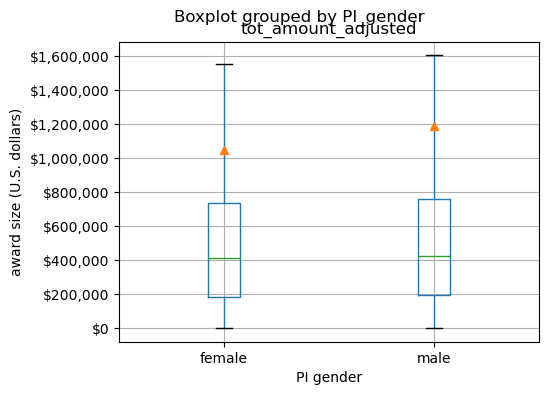

In [36]:
meanprops = dict(markeredgecolor='C1', markerfacecolor='C1')
fig, ax = plt.subplots()
_ = awards.boxplot('tot_amount_adjusted', by='PI_gender', showfliers=False, showmeans=True,
                   meanprops=meanprops, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(xlabel='PI gender', ylabel='award size (U.S. dollars)')
fig.subplots_adjust(left=0.2)

Box plot of the amount awarded to individual projects by male and female PIs in each year.

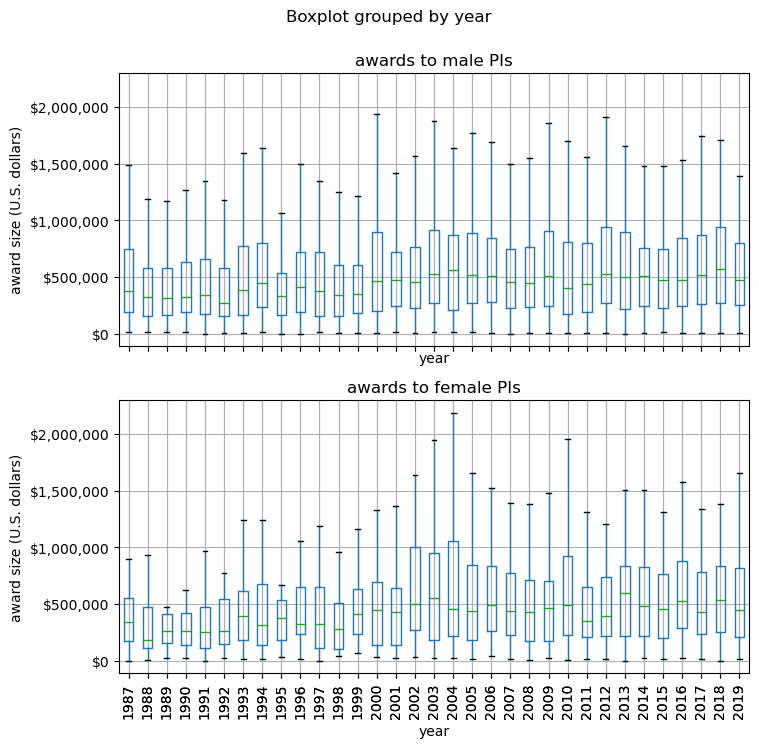

In [37]:
awards_male['year'] = awards_male.StartDate.dt.year
awards_female['year'] = awards_female.StartDate.dt.year
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(9,8))
_ = awards_male.boxplot('tot_amount_adjusted', by='year', showfliers=False, rot=90, ax=axs[0])
_ = awards_female.boxplot('tot_amount_adjusted', by='year', showfliers=False, rot=90, ax=axs[1])
axs[0].set_title('awards to male PIs')
axs[1].set_title('awards to female PIs')
for n in range(2):
    _ = axs[n].yaxis.set_major_formatter(fmt)
    _ = axs[n].set(ylabel='award size (U.S. dollars)')
fig.subplots_adjust(left=0.2)

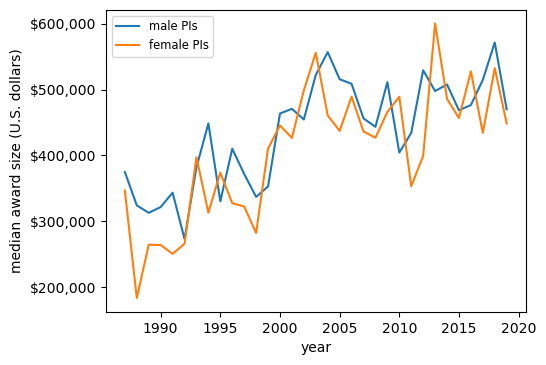

In [38]:
median_award = pd.DataFrame({'male PIs': awards_male.groupby('year')['tot_amount_adjusted'].median(),
                             'female PIs': awards_female.groupby('year')['tot_amount_adjusted'].median()})
fig, ax = plt.subplots()
_ = median_award.plot(ax=ax)
_ = ax.set(ylabel='median award size (U.S. dollars)')
_ = ax.yaxis.set_major_formatter(fmt)
fig.subplots_adjust(left=0.2)

t-test for equal means

In [39]:
import statsmodels.api as sm
male = awards_male.tot_amount_adjusted.values
female = awards_female.tot_amount_adjusted.values
tstat, pval, df = sm.stats.ttest_ind(male, female)
print('t={:.3f}, p={:.3f}, df={:.0f}'.format(tstat, pval, df))

t=0.452, p=0.651, df=11415
